<a href="https://colab.research.google.com/github/tomasonjo/blogs/blob/master/llm/llama_index_neo4j_custom_retriever.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install --quiet llama-index llama-index-graph-stores-neo4j llama-index-program-openai llama-index-llms-openai

In [23]:
import nest_asyncio

nest_asyncio.apply()

# Customizing property graph index in LlamaIndex
## Learn how to implement entity deduplication and custom retrieval methods to increase GraphRAG accuracy

The [property graph index](https://www.llamaindex.ai/blog/introducing-the-property-graph-index-a-powerful-new-way-to-build-knowledge-graphs-with-llms) is an excellent addition to LlamaIndex and an upgrade from the previous knowledge graph integration. First, the data representation is slightly different. In the previous integration, the graph was represented with triples, but now we have a proper property graph integration where nodes have labels and optionally node properties.

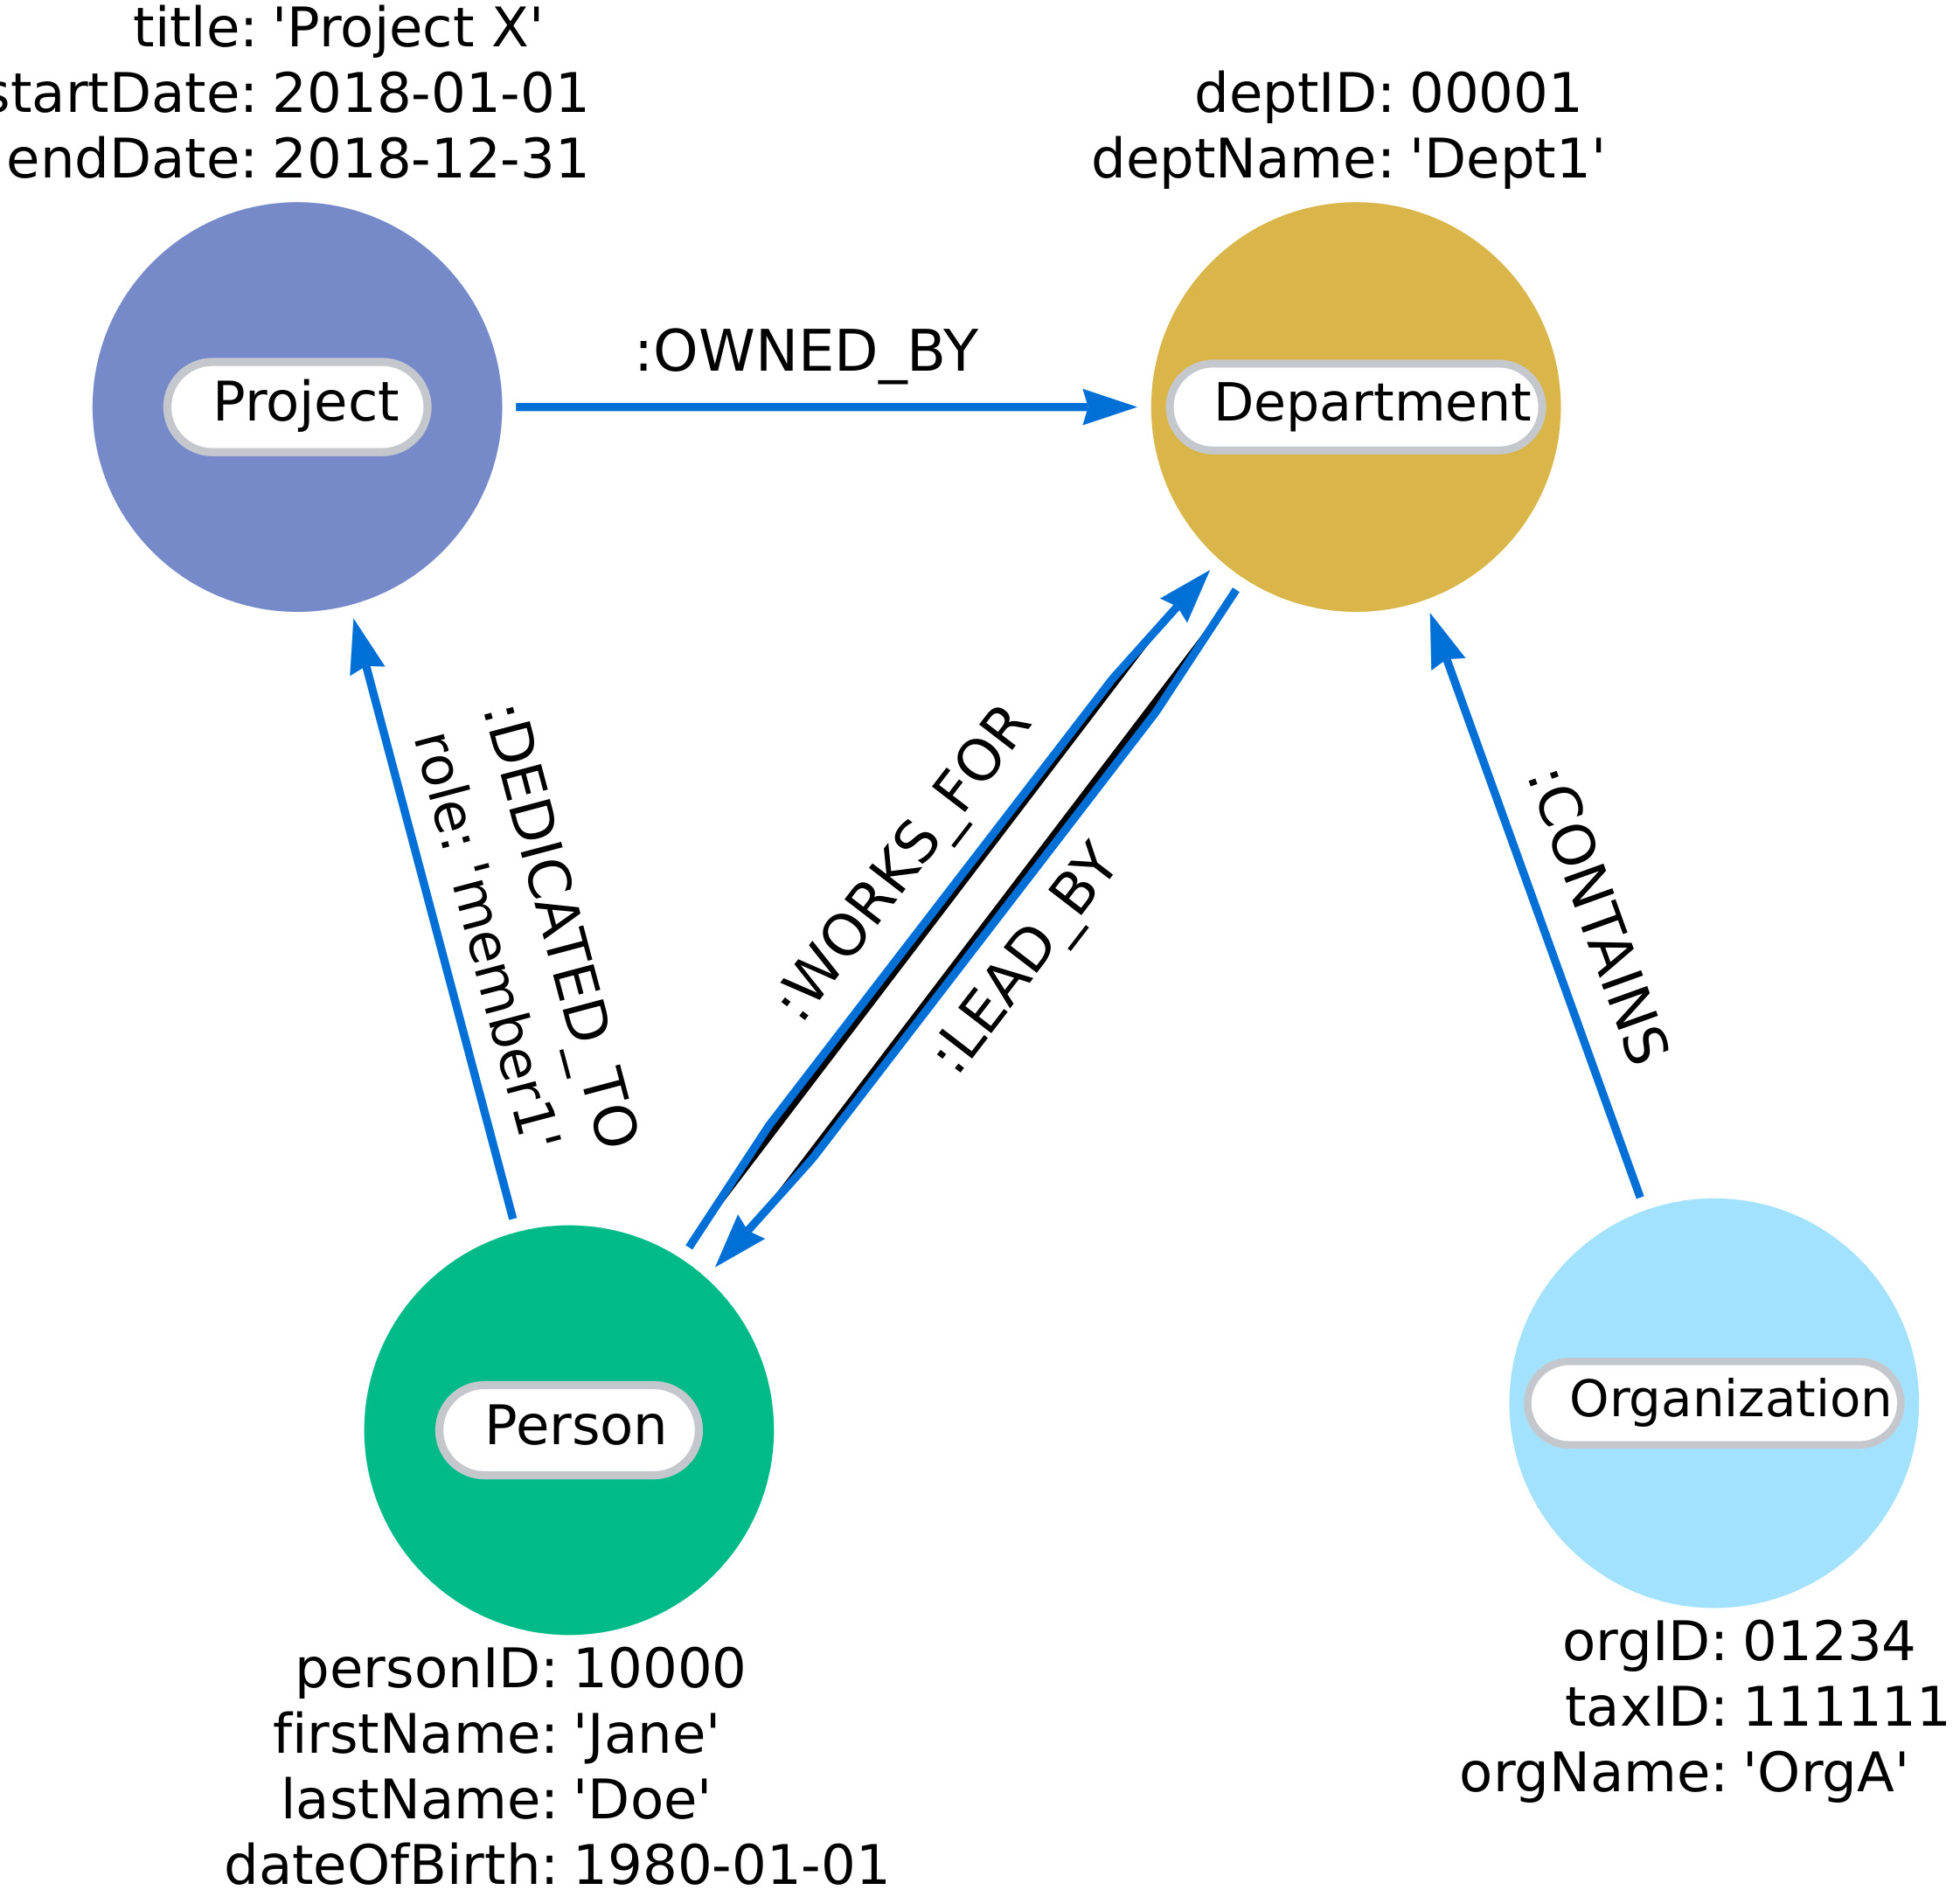

Each node is assigned a label indicating its type, such as Person, Organization, Project, or Department. Nodes and relationships may also store node properties for other relevant details, such as the date of birth or project start and end date, as shown in this example


Second, the property graph index is designed to be modular, so you can use one or multiple (custom) knowledge graph constructors as well as retrievers, making it an incredible tool to build your first knowledge graph or customize the implementation for your specific needs.
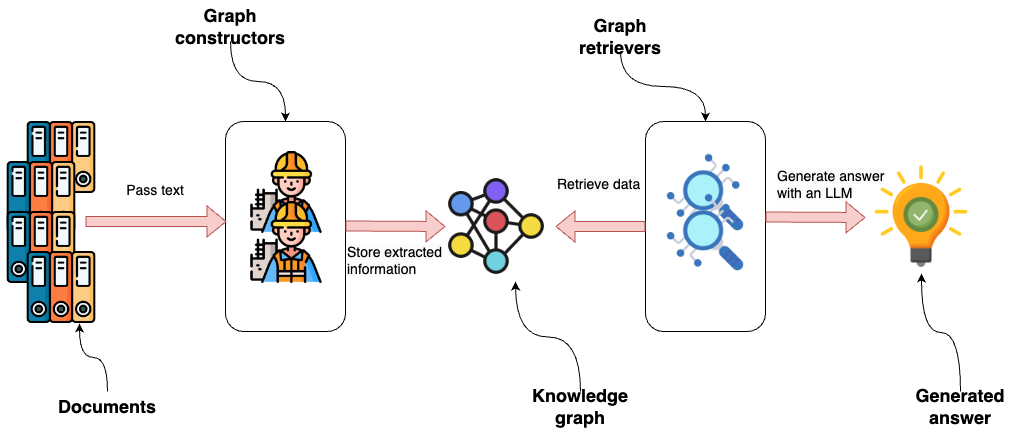

The image illustrates the property graph integration within the LlamaIndex , beginning with documents being passed to graph constructors. These constructors are modular components responsible for extracting structured information, which is then stored in a knowledge graph. The graph can be built using various or custom modules, highlighting the system's flexibility to adapt to different data sources or extraction needs.

Graph retrievers then access the knowledge graph to retrieve data. This stage is also modular, allowing for the use of multiple retrievers or custom solutions designed to query specific types of data or relationships within the graph. Finally, the retrieved data is used by a LLM to generate an answer, representing the output or the insight derived from the process. This flow emphasizes a highly adaptable and scalable system where each component can be independently modified or replaced to enhance the overall functionality or to tailor it to specific requirements.
In this blog post you will learn how to:
1. Construct a knowledge graph using a schema-guided extraction
2. Perform entity deduplication using a combination of text embedding and word similarity techniques
3. Design a custom graph retriever
4. Finally, you will implement a question answering flow using the custom retriever

# Environment setup
In this blog post, we will use Neo4j as the underlying graph store. The easiest way is to get started is to a free instance on Neo4j Aura, which offers cloud instances of the Neo4j database. Alternatively, you can also set up a local instance of the Neo4j database by downloading the Neo4j Desktop application and creating a local database instance.

In [3]:
from llama_index.graph_stores.neo4j import Neo4jPGStore

username="neo4j"
password="cradles-legends-assemblies"
url="bolt://18.212.1.253:7687"

graph_store = Neo4jPGStore(
    username=username,
    password=password,
    url=url,
)

Additionally, you will require a working OpenAI API key.

In [4]:
import os

os.environ["OPENAI_API_KEY"] = "sk-"

### Dataset
In this blog post, we will use a sample news article dataset fetched from Diffbot, which I've made available on GitHub for easier access. Since the property graph index operates with documents, we have to wrap the text from the news as LlamaIndex documents.

In [5]:
import pandas as pd
from llama_index.core import Document

news = pd.read_csv("https://raw.githubusercontent.com/tomasonjo/blog-datasets/main/news_articles.csv")
documents = [Document(text=f"{row['title']}: {row['text']}") for i, row in news.iterrows()]
news.head()

,title,date,text
0,Chevron: Best Of Breed,2031-04-06T01:36:32.000000000+00:00,JHVEPhoto Like many companies in the O&G secto...
1,FirstEnergy (NYSE:FE) Posts Earnings Results,2030-04-29T06:55:28.000000000+00:00,FirstEnergy (NYSE:FE – Get Rating) posted its ...
2,Dáil almost suspended after Sinn Féin TD put p...,2023-06-15T14:32:11.000000000+00:00,The Dáil was almost suspended on Thursday afte...
3,Epic’s latest tool can animate hyperrealistic ...,2023-06-15T14:00:00.000000000+00:00,"Today, Epic is releasing a new tool designed t..."
4,"EU to Ban Huawei, ZTE from Internal Commission...",2023-06-15T13:50:00.000000000+00:00,The European Commission is planning to ban equ...


#### Define Default LLMs

In [6]:
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.llms.openai import OpenAI

llm = OpenAI(model="gpt-4o", temperature=0.0)
embed_model = OpenAIEmbedding(model_name="text-embedding-3-small")

### Graph construction
As mentioned, LlamaIndex provides multiple out-of-the-box graph constructors. In this example, we will use the SchemaLLMPathExtractor, which allows us to define the schema of the graph structure we want to extract from documents. We begin by defining the types of nodes and relationships we want the LLM to extract.

In [7]:
from typing import Literal
from llama_index.core.indices.property_graph import SchemaLLMPathExtractor

# best practice to use upper-case
entities = Literal["PERSON", "LOCATION", "ORGANIZATION", "PRODUCT", "EVENT"]
relations = Literal[
    "SUPPLIER_OF",
    "COMPETITOR",
    "PARTNERSHIP",
    "ACQUISITION",
    "WORKS_AT",
    "SUBSIDIARY",
    "BOARD_MEMBER",
    "CEO",
    "PROVIDES",
    "HAS_EVENT",
    "IN_LOCATION",
]

As you can see, we are focusing our graph extraction around people and organizations. Next, we will specify the relationships associated with each node label.

In [ ]:
# define which entities can have which relations
validation_schema = {
    "Person": ["WORKS_AT", "BOARD_MEMBER", "CEO", "HAS_EVENT"],
    "Organization": [
        "SUPPLIER_OF",
        "COMPETITOR",
        "PARTNERSHIP",
        "ACQUISITION",
        "WORKS_AT",
        "SUBSIDIARY",
        "BOARD_MEMBER",
        "CEO",
        "PROVIDES",
        "HAS_EVENT",
        "IN_LOCATION",
    ],
    "Product": ["PROVIDES"],
    "Event": ["HAS_EVENT", "IN_LOCATION"],
    "Location": ["HAPPENED_AT", "IN_LOCATION"],
}

For example, a person can have the following relationships:
* WORKS_AT
* BOARD_MEMBER
* CEO
* HAS_EVENT

The schema is quite specific except for the `EVENT` node label, which is slightly more ambiguous and allows the LLM to capture various types of information.
Now that we have defined the graph schema, we can input it into the `SchemaLLMPathExtractor` and use it to construct a graph.

In [8]:
from llama_index.core import PropertyGraphIndex

kg_extractor = SchemaLLMPathExtractor(
    llm=llm,
    possible_entities=entities,
    possible_relations=relations,
    kg_validation_schema=validation_schema,
    # if false, allows for values outside of the schema
    # useful for using the schema as a suggestion
    strict=True,
)

NUMBER_OF_ARTICLES = 250

index = PropertyGraphIndex.from_documents(
    documents[:NUMBER_OF_ARTICLES],
    kg_extractors=[kg_extractor],
    llm=llm,
    embed_model=embed_model,
    property_graph_store=graph_store,
    show_progress=True,
)

Parsing nodes:   0%|          | 0/250 [00:00<?, ?it/s]

Generating embeddings: 100%|██████████| 46/46 [00:02<00:00, 16.68it/s]


The constructed graph contains both text chunks, which contain text and embeddings. If an entity was mentioned in the text chunk, there is a `MENTIONS` relationships between the text chunk and entity. Additionally, entities can have relationships to other entities.
### Entity deduplication
Entity deduplication or disambiguation is an important but often overlooked step in graph construction. Essentially, it is a cleaning step where you try to match multiple nodes that represent a single entity and merge them together into a single node for better graph structural integrity. We will use a combination of text embedding similarity and word distance to find potential duplicates. We start by defining the vector index on our entities in the graph.

In [9]:
graph_store.structured_query("""
CREATE VECTOR INDEX entity IF NOT EXISTS
FOR (m:`__Entity__`)
ON m.embedding
OPTIONS {indexConfig: {
 `vector.dimensions`: 1536,
 `vector.similarity_function`: 'cosine'
}}
""")

[]

The next Cypher query finds duplicates and is quite involved and I took me, Michael Hunger, and Eric Monk a couple of hours to perfect it.

In [16]:
# Just for inspection
similarity_threshold = 0.9
word_edit_distance = 5
data = graph_store.structured_query("""
MATCH (e:__Entity__)
CALL {
  WITH e
  CALL db.index.vector.queryNodes('entity', 10, e.embedding)
  YIELD node, score
  WITH node, score
  WHERE score > toFLoat($cutoff)
      AND (toLower(node.name) CONTAINS toLower(e.name) OR toLower(e.name) CONTAINS toLower(node.name)
           OR apoc.text.distance(toLower(node.name), toLower(e.name)) < $distance)
      AND labels(e) = labels(node)
  WITH node, score
  ORDER BY node.name
  RETURN collect(node) AS nodes
}
WITH distinct nodes
WHERE size(nodes) > 1
WITH collect([n in nodes | n.name]) AS results
UNWIND range(0, size(results)-1, 1) as index
WITH results, index, results[index] as result
WITH apoc.coll.sort(reduce(acc = result, index2 IN range(0, size(results)-1, 1) |
        CASE WHEN index <> index2 AND
            size(apoc.coll.intersection(acc, results[index2])) > 0
            THEN apoc.coll.union(acc, results[index2])
            ELSE acc
        END
)) as combinedResult
WITH distinct(combinedResult) as combinedResult
// extra filtering
WITH collect(combinedResult) as allCombinedResults
UNWIND range(0, size(allCombinedResults)-1, 1) as combinedResultIndex
WITH allCombinedResults[combinedResultIndex] as combinedResult, combinedResultIndex, allCombinedResults
WHERE NOT any(x IN range(0,size(allCombinedResults)-1,1)
    WHERE x <> combinedResultIndex
    AND apoc.coll.containsAll(allCombinedResults[x], combinedResult)
)
RETURN combinedResult
""", param_map={'cutoff': similarity_threshold, 'distance': word_edit_distance})
for row in data:
    print(row)

{'combinedResult': ['American Fork', 'American Fork, Utah']}
{'combinedResult': ['XPeng', 'XPeng Inc', 'Xpeng']}
{'combinedResult': ['Bank of America', 'Bank of America Corp.']}
{'combinedResult': ['bilingual STEM tutoring', 'bilingual STEM tutoring organization to close the educational gap for underserved students']}
{'combinedResult': ['Houston Texans', 'Texans']}
{'combinedResult': ['Hyatt', 'Hyatt Hotels']}
{'combinedResult': ['Star Ocean', 'Star Ocean 2', 'Star Ocean 2 remake', 'Star Ocean The Second Story', 'Star Ocean: Second Evolution', 'Star Ocean: The Second Story', 'Star Ocean: The Second Story R']}
{'combinedResult': ['Star Ocean First Departure R', 'Star Ocean: First Departure R']}
{'combinedResult': ['Citigroup', 'Citigroup Inc.']}
{'combinedResult': ['Wells Fargo', 'Wells Fargo & Co.']}
{'combinedResult': ['JPMorgan', 'JPMorgan Asset Management', 'JPMorgan Chase', 'JPMorgan Chase & Co.']}
{'combinedResult': ['Delhi', 'New Delhi']}
{'combinedResult': ['CarMax Auto Owner T

Without getting into too much details, we use a combination of text embeddings and word distance to find potential duplicates in our graph. You can tune similarity_threshold and word_distance to find the best combination that detects as many duplicates without too much false positives. Unfortunately, entity disambiguation is a hard problem and there are no perfect solutions. With this approach, we get quite good results, but there are some false positives in there as well. It is up to you to tweak the dials, and maybe add some manual exceptions before merging duplicate nodes.



In [21]:
graph_store.structured_query("""
MATCH (e:__Entity__)
CALL {
  WITH e
  CALL db.index.vector.queryNodes('entity', 10, e.embedding)
  YIELD node, score
  WITH node, score
  WHERE score > toFLoat($cutoff)
      AND (toLower(node.name) CONTAINS toLower(e.name) OR toLower(e.name) CONTAINS toLower(node.name)
           OR apoc.text.distance(toLower(node.name), toLower(e.name)) < $distance)
      AND labels(e) = labels(node)
  WITH node, score
  ORDER BY node.name
  RETURN collect(node) AS nodes
}
WITH distinct nodes
WHERE size(nodes) > 1
WITH collect([n in nodes | n.name]) AS results
UNWIND range(0, size(results)-1, 1) as index
WITH results, index, results[index] as result
WITH apoc.coll.sort(reduce(acc = result, index2 IN range(0, size(results)-1, 1) |
        CASE WHEN index <> index2 AND
            size(apoc.coll.intersection(acc, results[index2])) > 0
            THEN apoc.coll.union(acc, results[index2])
            ELSE acc
        END
)) as combinedResult
WITH distinct(combinedResult) as combinedResult
// extra filtering
WITH collect(combinedResult) as allCombinedResults
UNWIND range(0, size(allCombinedResults)-1, 1) as combinedResultIndex
WITH allCombinedResults[combinedResultIndex] as combinedResult, combinedResultIndex, allCombinedResults
WHERE NOT any(x IN range(0,size(allCombinedResults)-1,1)
    WHERE x <> combinedResultIndex
    AND apoc.coll.containsAll(allCombinedResults[x], combinedResult)
)
CALL {
  WITH combinedResult
	UNWIND combinedResult AS name
	MATCH (e:__Entity__ {name:name})
	WITH e
	ORDER BY size(e.name) DESC // prefer longer names to remain after merging
	RETURN collect(e) AS nodes
}
CALL apoc.refactor.mergeNodes(nodes, {properties: {
    `.*`: 'discard'
}})
YIELD node
RETURN count(*)
""", param_map={'cutoff': similarity_threshold, 'distance': word_edit_distance})

[{'count(*)': 85}]

### Implementing a custom retriever
Great, we have constructed a knowledge graph based on the news dataset. Now, let's examine our retriever options. At the moment, there are [four existing retrievers available](https://docs.llamaindex.ai/en/latest/module_guides/indexing/lpg_index_guide/#retrieval-and-querying):
* LLMSynonymRetriever: takes the query, and tries to generate keywords and synonyms to retrieve nodes (and therefore the paths connected to those nodes).
* VectorContextRetriever: retrieves nodes based on their vector similarity, and then fetches the paths connected to those nodes
* TextToCypherRetriever: uses a graph store schema, your query, and a prompt template in order to generate and execute a cypher query
* CypherTemplateRetriever: Rather than letting the LLM have free-range of generating any cypher statement, we can instead provide a cypher template and have the LLM fill in the parameters.

Additionally, implementing a custom retriever is straightforward, so that is exactly what we will do here. Our custom retriever will first identify entities in the input query and then execute the VectorContextRetriever for each identified entity separately.
First, we will define the entity extraction model and prompt.

In [24]:
from pydantic import BaseModel
from typing import Optional, List


class Entities(BaseModel):
    """List of named entities in the text such as names of people, organizations, concepts, and locations"""
    names: Optional[List[str]]


prompt_template_entities = """
Extract all named entities such as names of people, organizations, concepts, and locations
from the following text:
{text}
"""

Now we can progress to the custom retriever implementation.

In [25]:
from typing import Any, Optional

from llama_index.core.embeddings import BaseEmbedding
from llama_index.core.retrievers import CustomPGRetriever, VectorContextRetriever
from llama_index.core.vector_stores.types import VectorStore
from llama_index.program.openai import OpenAIPydanticProgram


class MyCustomRetriever(CustomPGRetriever):
    """Custom retriever with cohere reranking."""

    def init(
        self,
        ## vector context retriever params
        embed_model: Optional[BaseEmbedding] = None,
        vector_store: Optional[VectorStore] = None,
        similarity_top_k: int = 4,
        path_depth: int = 1,
        include_text: bool = True,
        **kwargs: Any,
    ) -> None:
        """Uses any kwargs passed in from class constructor."""
        self.entity_extraction = OpenAIPydanticProgram.from_defaults(
            output_cls=Entities, prompt_template_str=prompt_template_entities
        )
        self.vector_retriever = VectorContextRetriever(
            self.graph_store,
            include_text=self.include_text,
            embed_model=embed_model,
            similarity_top_k=similarity_top_k,
            path_depth=path_depth,
        )

    def custom_retrieve(self, query_str: str) -> str:
        """Define custom retriever with reranking.

        Could return `str`, `TextNode`, `NodeWithScore`, or a list of those.
        """
        entities = self.entity_extraction(text=query_str).names
        result_nodes = []
        if entities:
            print(f"Detected entities: {entities}")
            for entity in entities:
                result_nodes.extend(self.vector_retriever.retrieve(entity))
        else:
            result_nodes.extend(self.vector_retriever.retrieve(query_str))
        ## TMP: please change
        final_text = "\n\n".join(
            [n.get_content(metadata_mode="llm") for n in result_nodes]
        )
        return final_text


The MyCustomRetriever class has only two methods. You can use the init method to instantiate any functions or classes you will be using in the retriever. In this example, we instantiate the entity detection OpenAI program along with the vector context retriever.

The custom_retrieve method is called during retrieval. In our custom retriever implementation, we first identify any relevant entities in the text. If any entities are found, we iterate and execute the vector context retriever for each entity. On the other hand, if no entities are identified we pass the entire input to the vector context retriever.

As you can observe, you can easily customize the retriever for your use-case by incorporating existing retrievers or starting from scratch as you can easily execute Cypher statements by using the structured_query method of the graph store.
### Question-answering flow
Let's wrap it up by using the custom retriever to answer an example question. We need to pass the retriever to the RetrieverQueryEngine .

In [26]:
from llama_index.core.query_engine import RetrieverQueryEngine

custom_sub_retriever = MyCustomRetriever(
    index.property_graph_store,
    include_text=True,
    vector_store=index.vector_store,
    embed_model=embed_model
)

query_engine = RetrieverQueryEngine.from_args(
    index.as_retriever(sub_retrievers=[custom_sub_retriever]), llm=llm
)

### Try out some Queries

In [27]:
response = query_engine.query("What do you know about Maliek Collins or Darragh O’Brien?")
print(str(response))

Detected entities: ['Maliek Collins', "Darragh O'Brien"]
Maliek Collins is a defensive tackle who has played for the Dallas Cowboys, Las Vegas Raiders, and Houston Texans. Recently, he signed a two-year contract extension with the Houston Texans worth $23 million, including a $20 million guarantee. This new deal represents a raise from his previous contract, where he earned $17 million with $8.5 million guaranteed. Collins is expected to be a key piece in the Texans' defensive line and fit well into their 4-3 alignment.

Darragh O’Brien is the Minister for Housing and has been involved in the State’s industrial relations process and the Government. He was recently involved in a debate in the Dáil regarding the pay and working conditions of retained firefighters, which led to a heated exchange and almost resulted in the suspension of the session. O’Brien expressed confidence that the dispute could be resolved and encouraged unions to re-engage with the industrial relations process.


### Summary
In this blog post, we've explored the intricacies of customizing the property graph index within LlamaIndex, focusing on implementing entity deduplication and designing custom retrieval methods to enhance GraphRAG accuracy. The property graph index allows for a modular and flexible approach, utilizing various graph constructors and retrievers to tailor the implementation to your specific needs. Whether you're building your first knowledge graph or optimizing for a unique dataset, these customizable components offer a powerful toolkit. We invite you to test out the property graph index integration to see how they can elevate your knowledge graph projects.